# 627 Project 2
## Statoil/C-CORE Iceberg Classifier Challenge

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pprint import pprint

import tensorflow as tf
import os

In [3]:
# Help function to read in the data and process
def read_jason(file_path):
    # Read file with panda jason
    df = pd.read_json(file_path)
    # Repalce missing value with -1
    df['inc_angle'] = df['inc_angle'].replace('na', -1).astype(float)
    # reshape bands
    band1 = np.array([np.array(band).astype(np.float32) for band in df["band_1"]])
    band2 = np.array([np.array(band).astype(np.float32) for band in df["band_2"]])
    df = df.drop(['band_1', 'band_2'], axis=1)
    return df, band1, band2

In [83]:
# Help function to show plot
def show_plt(data, bands, shape=(75,75), prediction=[], test=False):
    figsize(10,10)
    res = ['Ship', 'Ice_Berg']
    for idx, band in enumerate(bands):
        subplot(3,3,idx+1)
        imshow(band.reshape(shape))
        axis('off')
        name = 'Angle ' + str(data.inc_angle[idx]) 
        title(name)
        if not test:
            if len(prediction)>0:
                text(15, 80, 'True:'+res[data.is_iceberg[idx]]+', pred:'+res[prediction[idx]])
            else:
                text(30, 80, 'True:'+res[data.is_iceberg[idx]])

First we read the train and test data to have a good preview.

In [78]:
json_path = 'data/processed/train.json'
train, band1, band2 = read_jason(json_path)
test_json_path = 'data/processed/test.json'
test, test_band1, test_band2 = read_jason(test_json_path)

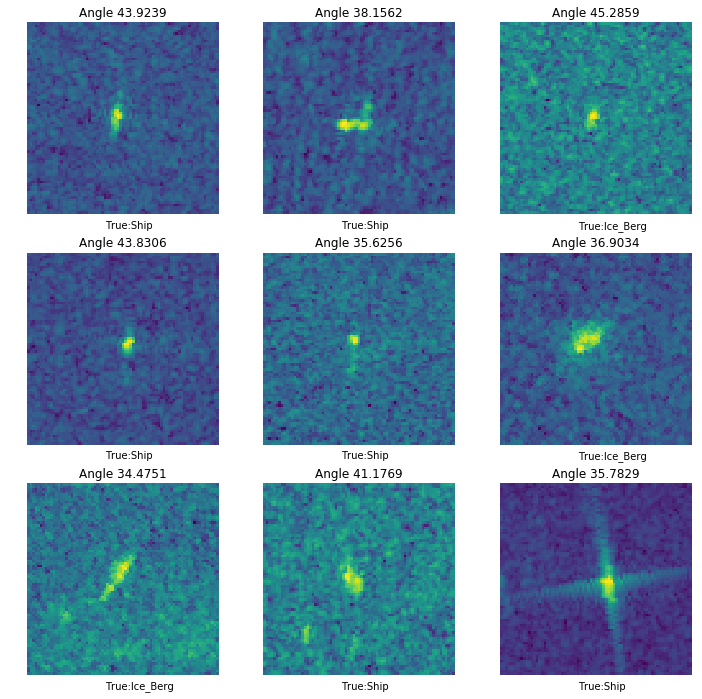

In [80]:
show_plt(train, band1[:9])

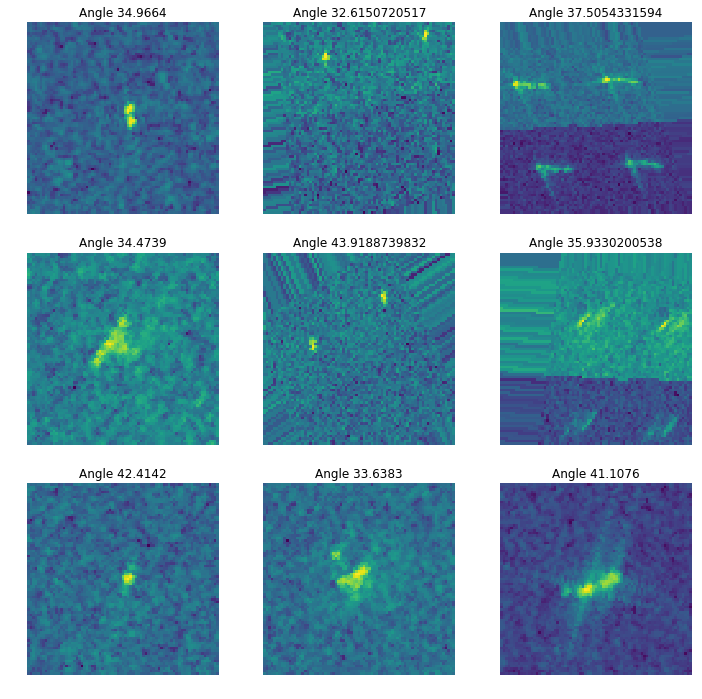

In [81]:
show_plt(test, test_band1[:9], test=True)

### Set up a net 

In [7]:
tf.reset_default_graph()

In [8]:
num_inputs = 75*75
num_outputs = 2

In [9]:
with tf.name_scope('input'):
    x = tf.placeholder(tf.float32, (None, num_inputs), name='x')
    y = tf.placeholder(tf.float32, (None, num_outputs), name='y')
    ec = tf.argmax(y, 1, name='ec') #[e]xpected [c]lass label
    tf.summary.image("image", tf.reshape(x, [-1, 75,75,1]), max_outputs=3);

In [10]:
with tf.name_scope('output'):
    b = tf.Variable(tf.zeros(num_outputs), name='b')
    W = tf.Variable(tf.truncated_normal([num_inputs, num_outputs]), name='W')
    a = tf.add(tf.matmul(x, W), b, name='a')
    z = tf.nn.softmax(a, name='z')
    pc = tf.argmax(z, 1, name='pc')  # [p]redicted [c]lass label
    
    # Create nodes that will save histograms to the log file
    #  -- histograms are good summaries of the (large) amount of data in the weights. 
    #  -- The let you spot common issues with gradient descent (stalling, diverging)
    tf.summary.histogram("weights", W)
    tf.summary.histogram("biases", b)
    tf.summary.histogram("activations", pc)

In [11]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

x_batch = band1[:9]
y_batch = array([[float32(i), abs(float32(i)-1)] for i in train.is_iceberg[:9]])
predictions = sess.run(pc, {x:x_batch, y:y_batch})

In [12]:
predictions

array([0, 0, 0, 0, 0, 0, 0, 0, 0])

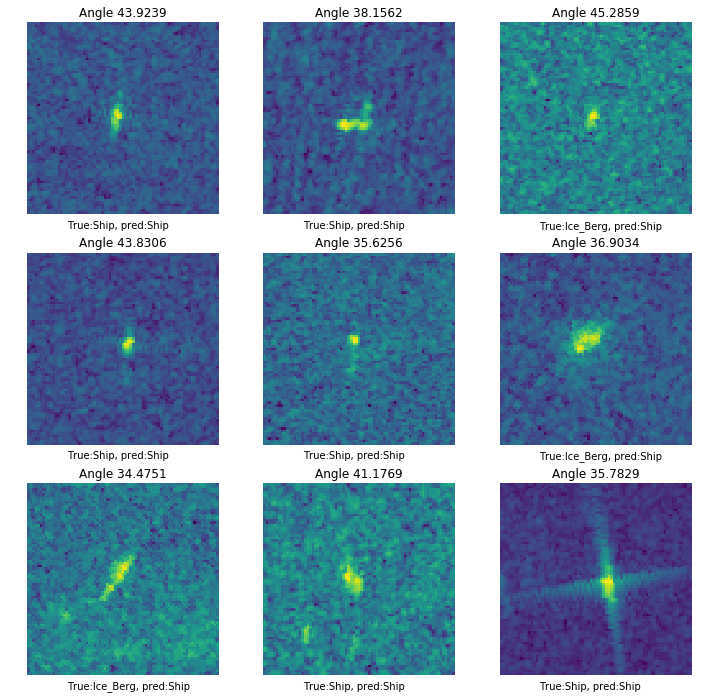

In [13]:
show_plt(train, x_batch, prediction=predictions)

In [14]:
with tf.name_scope('accuracy'):
    correct = tf.equal(ec, pc, name='correct')  # for each sample, did we get it right? 
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name='acc')

    # Create a node to save the accuracy to a log file, 
    # so that we can go back and see how it improves after training. 
    tf.summary.scalar('accuracy', accuracy);

In [40]:
test_data = band1
test_label = array([[float32(i), abs(float32(i)-1)] for i in train.is_iceberg])

In [41]:
print "Accuracy:", sess.run(accuracy, {x:test_data, y:test_label})

Accuracy: 0.998753


### Save the log / summary data

In [17]:
summary = tf.summary.merge_all()

In [18]:
summary_writer = tf.summary.FileWriter('./proj/log/run0/', graph=sess.graph)

In [19]:
test_data.shape

(1604, 5625)

In [20]:
test_label.shape

(1604, 2)

In [21]:
acc, log = sess.run([accuracy, summary], 
                    {x:test_data, y:test_label})
summary_writer.add_summary(log, 0)

In [22]:
from pipes import quote
print "Acuracy:", acc
print 
print "Make sure the correct conda environment is active, then run:"
print "    tensorboard --logdir={} ".format(quote(os.path.abspath('./log')))
print "and open"
print "    http://localhost:6006/"
print "using your web browser"

Acuracy: 0.483791

Make sure the correct conda environment is active, then run:
    tensorboard --logdir=/home/liuz10/Documents/proj2/627_Project2/log 
and open
    http://localhost:6006/
using your web browser


### Set up the graph for training

In [23]:
with tf.name_scope('loss'):
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=a)
    loss = tf.reduce_mean(cross_entropy, name='loss')

    # And define a node to log it
    tf.summary.scalar('loss', loss);

In [24]:
with tf.name_scope('solver'):
    solver = tf.train.AdamOptimizer()
    optimize = solver.minimize(loss)

In [25]:
summary_writer = tf.summary.FileWriter('./proj/log/run1/', graph=sess.graph)

In [26]:
# The solver has some parameters that need to be initializes
sess.run(tf.global_variables_initializer())

In [27]:
# Add ops to save and restore all the variables.
saver = tf.train.Saver()

In [29]:
 # Training cycle
batch_size=100
training_epochs=10000
display_epoch=1
length = len(band1)
lossesss = []

try:
    saver.restore(sess, './models/logreg.cpt')
except:
    print "No model to restore"

for epoch in range(training_epochs):
    avg_loss = 0.
    total_batch = int(length/batch_size)
    
    for i in range(total_batch):
        start = i * batch_size
        
        if start + batch_size < length:
            batch_xs = band1[start:start+batch_size]
            batch_ys = array([[float32(i), abs(float32(i)-1)] for i in train.is_iceberg[start:start+batch_size]])
        else:
            batch_xs = band1[start:]
            batch_ys = array([[float32(i), abs(float32(i)-1)] for i in train.is_iceberg[start:]])
            
        _, loss_, summary_ = sess.run([optimize, loss, summary],
                                    {x: batch_xs, y: batch_ys})
        
        global_iteration =  epoch * total_batch + i
        summary_writer.add_summary(summary_, global_iteration)
        
        avg_loss += loss_ / total_batch
    
    # Display logs per epoch step
    if (epoch+1) % display_epoch == 0:
        print "\r Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(avg_loss),
    lossesss.append(avg_loss)
    
    
    saver.save(sess, './models/logreg.cpt')

INFO:tensorflow:Restoring parameters from ./models/logreg.cpt
No model to restore
 Epoch: 10000 cost= 0.000000707                                                  cost= 96.760810852                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

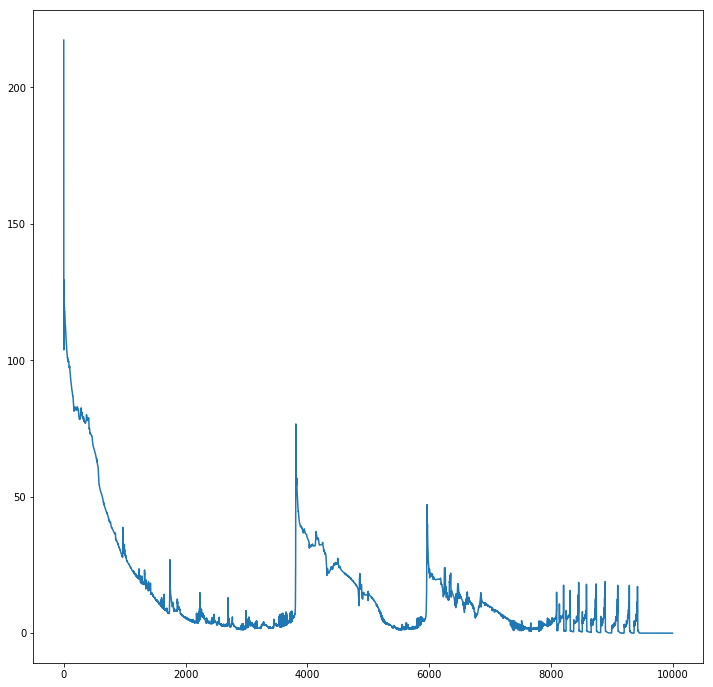

In [30]:
plot(lossesss)

In [37]:
pred = sess.run(pc, {x:band1, y:array([[float32(i), abs(float32(i)-1)] for i in train.is_iceberg])})

In [45]:
print "Accuracy:", sess.run(accuracy, {x:test_data, y:test_label})

Accuracy: 0.998753


### Generate prediction result

In [46]:
test_json_path = 'data/processed/test.json'
test, test_band1, test_band2 = read_jason(test_json_path)

In [48]:
pre = sess.run(pc, {x:test_band1})

In [53]:
res = []
for idx, i in enumerate(test.id):
    res.append((i, pre[idx]))

In [64]:
res = array(res)
res = res.transpose(1,0)
dic = {'id':res[0], 'is_iceberg':res[1]}

In [68]:
res_table = pd.DataFrame.from_dict(dic)
res_table
# Save into a csv file
CSV_FILE='/home/liuz10/Desktop/res.csv'
res_table.to_csv(CSV_FILE, index=False)

In [ ]:
# TODO: Try to get the result back

In [ ]:
# n = 75*75*2
# s1 = np.zeros(n)
# s2 = np.zeros((n,n))
# m = len(bands)
# for i, image in enumerate(bands):
#     x = image.flatten()
#     s1 += x
#     s2 += np.outer(x,x)
#     print "\r{:5}/{}".format(i+1, m),

# mu = s1/m
# var = s2/m - np.outer(mu, mu)

In [ ]:
# print mu, var

# variances, components = np.eigh(var)

# variances /= variances.sum()

# contribution = np.cumsum(variances)

# train